<a href="https://colab.research.google.com/github/Aaron3013352/customer-churn-prediction/blob/main/notebooks/03_modeling_sql_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

DATA_PATH = "/content/sample_data/churn_features.parquet"
df = pd.read_parquet(DATA_PATH)

print(df.shape)
df.head()


(7043, 22)


,churn_label,Count,Tenure Months,Monthly Charges,Total Charges,CLTV,Gender,Senior Citizen,Partner,Dependents,...,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method
0,Yes,1,2,53.85,108.15,3239,Male,No,No,No,...,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
1,Yes,1,2,70.70,151.65,2701,Female,No,No,Yes,...,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
2,Yes,1,8,99.65,820.5,5372,Female,No,No,Yes,...,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
3,Yes,1,28,104.80,3046.05,5003,Female,No,Yes,Yes,...,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check
4,Yes,1,49,103.70,5036.3,5340,Male,No,No,Yes,...,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic)


In [2]:
df.info()
df["churn_label"].value_counts(dropna=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   churn_label        7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Tenure Months      7043 non-null   int64  
 3   Monthly Charges    7043 non-null   float64
 4   Total Charges      7043 non-null   object 
 5   CLTV               7043 non-null   int64  
 6   Gender             7043 non-null   object 
 7   Senior Citizen     7043 non-null   object 
 8   Partner            7043 non-null   object 
 9   Dependents         7043 non-null   object 
 10  Phone Service      7043 non-null   object 
 11  Multiple Lines     7043 non-null   object 
 12  Internet Service   7043 non-null   object 
 13  Online Security    7043 non-null   object 
 14  Online Backup      7043 non-null   object 
 15  Device Protection  7043 non-null   object 
 16  Tech Support       7043 

,count
churn_label,
No,5174
Yes,1869


In [3]:
import pandas as pd

df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce")
print("NaNs in Total Charges:", df["Total Charges"].isna().sum())
df[["Total Charges"]].head()


NaNs in Total Charges: 11


,Total Charges
0,108.15
1,151.65
2,820.50
3,3046.05
4,5036.30


In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["churn_label"])
y = df["churn_label"]  # keep as 'Yes'/'No' for now

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Train churn rate:\n", y_train.value_counts(normalize=True))
print("Val churn rate:\n", y_val.value_counts(normalize=True))
print("Test churn rate:\n", y_test.value_counts(normalize=True))


Train: (4930, 21) Val: (1056, 21) Test: (1057, 21)
Train churn rate:
 churn_label
No     0.734686
Yes    0.265314
Name: proportion, dtype: float64
Val churn rate:
 churn_label
No     0.734848
Yes    0.265152
Name: proportion, dtype: float64
Test churn rate:
 churn_label
No     0.734153
Yes    0.265847
Name: proportion, dtype: float64


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# identify numeric vs categorical columns
num_features = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_features = X_train.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

baseline_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)),
])

baseline_model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Count', 'Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(h...
                                                  Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [6]:
baseline_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Count', 'Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(h...
                                                  Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [7]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

y_val_pred = baseline_model.predict(X_val)
y_val_proba = baseline_model.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))
print("PR-AUC :", average_precision_score(y_val, y_val_proba, pos_label="Yes"))


              precision    recall  f1-score   support

          No       0.92      0.71      0.80       776
         Yes       0.51      0.82      0.62       280

    accuracy                           0.74      1056
   macro avg       0.71      0.76      0.71      1056
weighted avg       0.81      0.74      0.75      1056

ROC-AUC: 0.8483937776141384
PR-AUC : 0.631454882845343


In [8]:
y_val_proba[:10]


array([0.02103695, 0.81216565, 0.24223786, 0.09659165, 0.86951424,
       0.91080356, 0.82456149, 0.31905386, 0.68388916, 0.10238231])

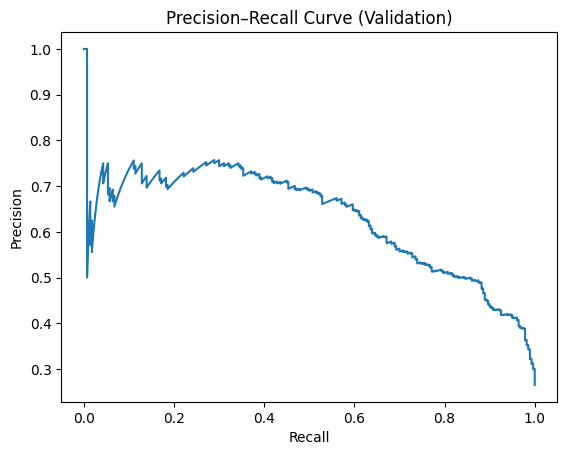

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_val, y_val_proba, pos_label="Yes"
)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Validation)")
plt.show()


In [10]:
precision[:5], recall[:5], thresholds[:5]


(array([0.26515152, 0.26540284, 0.26565465, 0.26590693, 0.2661597 ]),
 array([1., 1., 1., 1., 1.]),
 array([0.00171001, 0.00177147, 0.00178871, 0.00187023, 0.00189685]))

In [11]:
import numpy as np

target_recall = 0.80
min_precision = 0.40

valid_idxs = np.where(
    (recall[:-1] >= target_recall) &
    (precision[:-1] >= min_precision)
)[0]

len(valid_idxs), valid_idxs[:5]


(238, array([381, 382, 383, 384, 385]))

In [12]:
best_idx = valid_idxs[0]
custom_threshold = thresholds[best_idx]

print("Chosen threshold:", custom_threshold)
print("Precision:", precision[best_idx])
print("Recall:", recall[best_idx])


Chosen threshold: 0.20350006212846572
Precision: 0.4
Recall: 0.9642857142857143


In [13]:
from sklearn.metrics import classification_report

y_val_custom = (y_val_proba >= custom_threshold).astype(int)
y_val_binary = (y_val == "Yes").astype(int)

print("VALIDATION SET RESULTS")
print(classification_report(y_val_binary, y_val_custom))


VALIDATION SET RESULTS
              precision    recall  f1-score   support

           0       0.97      0.48      0.64       776
           1       0.40      0.96      0.57       280

    accuracy                           0.61      1056
   macro avg       0.69      0.72      0.60      1056
weighted avg       0.82      0.61      0.62      1056



In [14]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score

y_test_proba = baseline_model.predict_proba(X_test)[:, 1]
y_test_custom = (y_test_proba >= custom_threshold).astype(int)
y_test_binary = (y_test == "Yes").astype(int)

print("TEST SET RESULTS")
print("ROC-AUC:", roc_auc_score(y_test_binary, y_test_proba))
print("PR-AUC :", average_precision_score(y_test_binary, y_test_proba))
print("Precision:", precision_score(y_test_binary, y_test_custom))
print("Recall   :", recall_score(y_test_binary, y_test_custom))
print("F1       :", f1_score(y_test_binary, y_test_custom))


TEST SET RESULTS
ROC-AUC: 0.8586785046043218
PR-AUC : 0.6875661054044604
Precision: 0.40296296296296297
Recall   : 0.9679715302491103
F1       : 0.5690376569037657


## Final Test Set Evaluation

Using a decision threshold selected on the validation set to prioritize churn recall,
the model achieves strong generalization performance on the held-out test set.

This operating point reflects a retention-focused strategy where missing a churner
is more costly than contacting a non-churner.
